# Simple properties with single calculation

There are many properties that only require a single DFT calculation to obtain:
- energy
- forces
- density of states
- electron density 
- electrostatic potential. 

This section describes some of these calculations and their analysis.

We use `gpaw.GPAW` caclulator, see all its [input parameters](https://wiki.fysik.dtu.dk/gpaw/documentation/basic.html#parameters)

## Energy and forces

Two of the most important quantities are the total energy and the forces on the atoms. 

Here is an example of getting the energy and forces from a CO molecule. 

In [1]:
from ase import Atoms, Atom
from gpaw import GPAW, PW
import matplotlib.pyplot as plt

In [10]:
# Define molecule
co = Atoms([Atom('C', [0, 0, 0]),
            Atom('O', [1.2, 0, 0])],
           cell=(6., 6., 6.), )

# gpaw calculator:
calc = GPAW(mode=PW(550),       # planewave cutoff  350
            xc='PBE',             # the exchange-correlation functional
            nbands=6,             # number of bands
            occupations={'name': 'methfessel-paxton', 'width': 0.01, 'order': 0},    # Methfessel-Paxton smearing
            txt='molecules/simple_CO.out')   # output file

co.calc = calc     # set calculator
energy = co.get_potential_energy()
force = co.get_forces()

## write restart file
calc.write('molecules/simple_CO.gpw')

print('energy = {0} eV'.format(energy))
print(force)

energy = -14.762042929054388 eV
[[ 5.68157983e+00  3.80295547e-30  0.00000000e+00]
 [-5.67924814e+00  0.00000000e+00  0.00000000e+00]]


Note that the forces are only along the x-axis, which is along the molecular axis. The forces in this case are very high, indicating that this geometry is not close to the ground state geometry.We need to minimize system.

### Convergence with size of unit cell

There are a number of parameters that affect the energy and forces including 
- calculation parameters and
- the unit cell.

We will first consider the *effect of the unit cell* on the total energy and forces. The reason that the unit cell affects the total energy is that it can change the distribution of electrons in the molecule.

In [11]:
calc = GPAW(mode=PW(550),       # planewave cutoff  350
            xc='PBE', txt=None)

atoms = Atoms([Atom('C', [0, 0, 0]),
            Atom('O', [1.2, 0, 0])],)

## change cell size
L = [5, 6, 8, 10, 12]
energies = []
for a in L:
    atoms.set_cell([a, a, a], scale_atoms=False)
    atoms.center()
    atoms.calc = calc
    energies.append(atoms.get_potential_energy())
    ## write restart file
    calc.write('molecules/simple_CO_L{}.gpw'.format(a))

print(energies)

[-14.923865034147486, -14.76124106128068, -14.731890867379088, -14.718057285375425, -14.720085450475642]


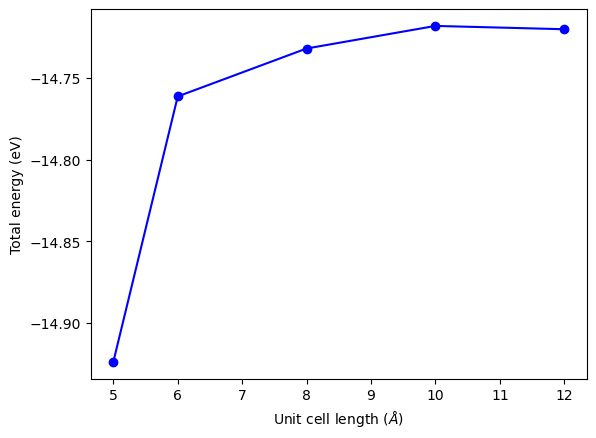

In [13]:
plt.plot(L, energies, 'bo-')
plt.xlabel('Unit cell length ($\AA$)')
plt.ylabel('Total energy (eV)')
plt.show()

Here there are evidently attractive interactions between the CO molecules which lower the total energy for *small* box sizes. We have to decide what an appropriate volume for our calculation is, and the choice depends on the goal. We may wish to know the total energy of a molecule that is not interacting with any other molecules, e.g. in the ideal gas limit. In that case we need a large unit cell so the electron density from the molecule does not go outside the unit cell where it would overlap with neighboring images.

It pays to check for convergence. The cost of running the calculation goes up steeply with increasing cell size. Doubling a lattice vector here leads to a 20-fold increase in computational time! Note that doubling a lattice vector length increases the volume by a factor of 8 for a cube. The cost goes up because the number of planewaves that fit in the cube grows as the cube gets larger.

### Convergence of energy Cutoff

The total energy and forces also depend on the computational parameters, notably [energy cutoff](https://wiki.fysik.dtu.dk/gpaw/tutorialsexercises/structureoptimization/stress/stress.html) ENCUT.

In [24]:
atoms = Atoms([Atom('C', [0, 0, 0]),
            Atom('O', [1.2, 0, 0])],
           cell=(6., 6., 6.))
atoms.center()

## Change plane wave cutoff
ENCUTS = [300, 350, 400, 450, 500, 600]
energies = []
for en in ENCUTS:
    calc = GPAW(mode=PW(ecut=en), xc='PBE', txt=None)
    atoms.calc = calc
    energies.append(atoms.get_potential_energy())

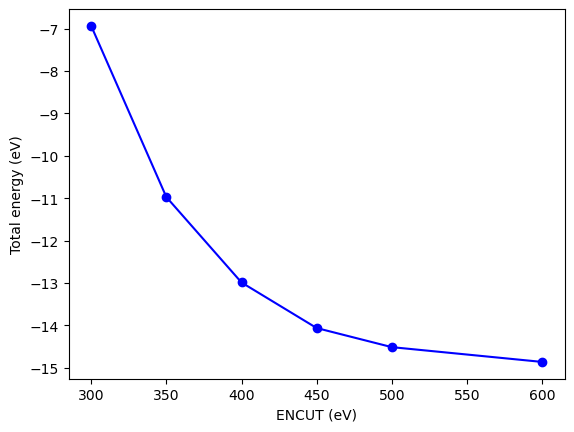

In [25]:
## Plot
plt.plot(ENCUTS, energies, 'bo-')
plt.xlabel('ENCUT (eV)')
plt.ylabel('Total energy (eV)')
plt.show()

Keep in mind that 
- we are generally interested in differences in total energy, and the differences tend to converge faster than a single total energy. 
- Also it is important to note that it is usually a single element that determines the rate of convergence. 
- The reason we do not just use very high ENCUT all the time is it is expensive.

## Visualizing electron density

The electron density is a 3D quantity: for every $(x,y,z)$ point, there is a *charge density*. That means we need 4 numbers for each point: $(x,y,z)$ and $\rho(x,y,z)$. Below we show an example of plotting the charge density, and we consider some issues we have to consider when visualizing volumetric data in unit cells with periodic boundary conditions. We will use the results from a previous calculation.

[Visualizing electron density compute by GPAW](https://www.brown.edu/Departments/Engineering/Labs/Peterson/tips/ElectronDensity/index.html)
- First, the all-electron density distribution around a molecule is calculated in GPAW. 
- All electron density data as well as grid points on which the density is represented are saved to files.
- Then use 3D plot to visualize data.

**Pakages**
```
pip install mayavi  # mayavi from conda-forge may cause error
```

to solve error `libGL.so.1`
```
sudo apt-get update 
sudo apt-get install libgl1
```

NOTE: 
- restart a calculation [in GPAW](https://wiki.fysik.dtu.dk/gpaw/documentation/restart_files.html)
- GPAW [parameters](https://wiki.fysik.dtu.dk/gpaw/documentation/basic.html#parameters)

In [27]:
from gpaw import GPAW, restart
from ase.io import write
import numpy as np

## compute all-electron density
atoms, calc = restart('molecules/simple_CO.gpw')  # read file from previous calc
density = calc.get_all_electron_density(gridrefinement=2)
write('molecules/density_co.cube', atoms, data=density)

grid = calc.hamiltonian.gd.get_grid_point_coordinates()
np.save('molecules/grid_co.npy', grid)

In [28]:
from ase.io.cube import read_cube_data
from ase.visualize import mlab

# Read the electron density data from the GPAW cube file
density, atoms = read_cube_data('molecules/density_co.cube')

mlab.plot(atoms, density)

TypeError: plot() missing 1 required positional argument: 'contours'

In [31]:
from mayavi import mlab
from ase.io.cube import read_cube_data
from ase.data import vdw_radii


# Read the electron density data from the GPAW cube file
density, atoms = read_cube_data('molecules/density_co.cube')

# make a white figure
mlab.figure(1, bgcolor=(1, 1, 1), size=(650, 650))

# Create the Mayavi volume object
source = mlab.pipeline.scalar_field(density)
mlab.pipeline.volume(source)

# Adjust the color map and isosurface level
source = mlab.pipeline.scalar_field(density)
min = density.min()
max = density.max()
vol = mlab.pipeline.volume(source, vmin=min + 0.65 * (max - min),
                                   vmax=min + 0.9 * (max - min))

# # Add axes and labels
# mlab.axes()
# mlab.xlabel('X')
# mlab.ylabel('Y')
# mlab.zlabel('Z')

# # make a white figure
# mlab.figure(1, bgcolor=(1, 1, 1), size=(350, 350))

# # plot the atoms as spheres
# for atom in atoms:
#     mlab.points3d(atom.x, atom.y, atom.z,
#                   scale_factor=vdw_radii[atom.number] / 5.,  #this determines the size of the atom
#                   resolution=20,
#                   scale_mode='none')

# Show the plot
mlab.show()

## The density of states (DOS)
The density of states (DOS) gives you the number of electronic states (i.e., the orbitals) that have a particular energy. A brief introduction in [GPAW page](https://wiki.fysik.dtu.dk/gpaw/tutorialsexercises/electronic/pdos/pdos.html)

A GPAW calculator gives access to four different kinds of projected density of states:
- Total density of states.
- Molecular orbital projected density of states.
- Atomic orbital projected density of states.
- Wigner-Seitz local density of states.

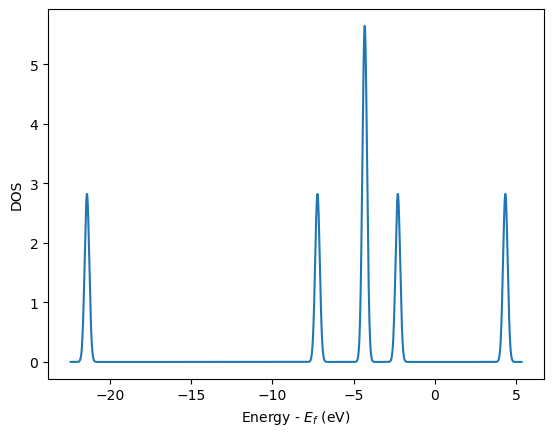

In [33]:
from gpaw import GPAW, restart
import matplotlib.pyplot as plt

atoms, calc = restart('molecules/simple_co.gpw')    # we already ran this!
e, dos = calc.get_dos(spin=0, npts=2001, width=0.2)
e_f = calc.get_fermi_level()
plt.plot(e - e_f, dos)
plt.xlabel('Energy - $E_f$ (eV)')
plt.ylabel('DOS')
plt.show()

## Electrostatic potential

This is an example of the so-called $\sigma$ hole in a halogen bond. The coordinates for the $CF_3Br$ molecule were found at [this link](http://cccbdb.nist.gov/exp2.asp?casno=75638).